In [2]:
libs <- c('data.table', 'stargazer', 'dplyr', 'Hmisc')
sapply(libs, require, character.only = T, quietly = T)

data.table  stargazer      dplyr      Hmisc 
      TRUE       TRUE       TRUE       TRUE

In [3]:
Data_collection <- list(Data_GeoNetwork = fread('../Data_GeoNetwork.csv')[, V1 := NULL],
                        Data_Audience = fread('../Data_Audience.csv')[, V1 := NULL])

In [24]:
Hmisc::describe(Data_collection$Data_GeoNetwork[,.(country, city, sessionDuration, bounces, sessions)])

Data_collection$Data_GeoNetwork[, .(country, city, sessionDuration, bounces, sessions)] 

 5  Variables      1791  Observations
--------------------------------------------------------------------------------
country 
       n  missing distinct 
    1791        0        2 
                                      
Value             Canada United States
Frequency            108          1683
Proportion          0.06          0.94
--------------------------------------------------------------------------------
city 
       n  missing distinct 
    1791        0      955 

lowest : (not set)   Abbotsford  Acworth     Addis       Adrian     
highest: Wyndham     Yorba Linda Yuba City   Yukon       Zimmerman  
--------------------------------------------------------------------------------
sessionDuration 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
    1791        0      437        1    163.6    248.1      4.0      6.0 
     .25      .50      .75      .90      .95

### $Session~Duration\sim Country$ (Gamma regression)

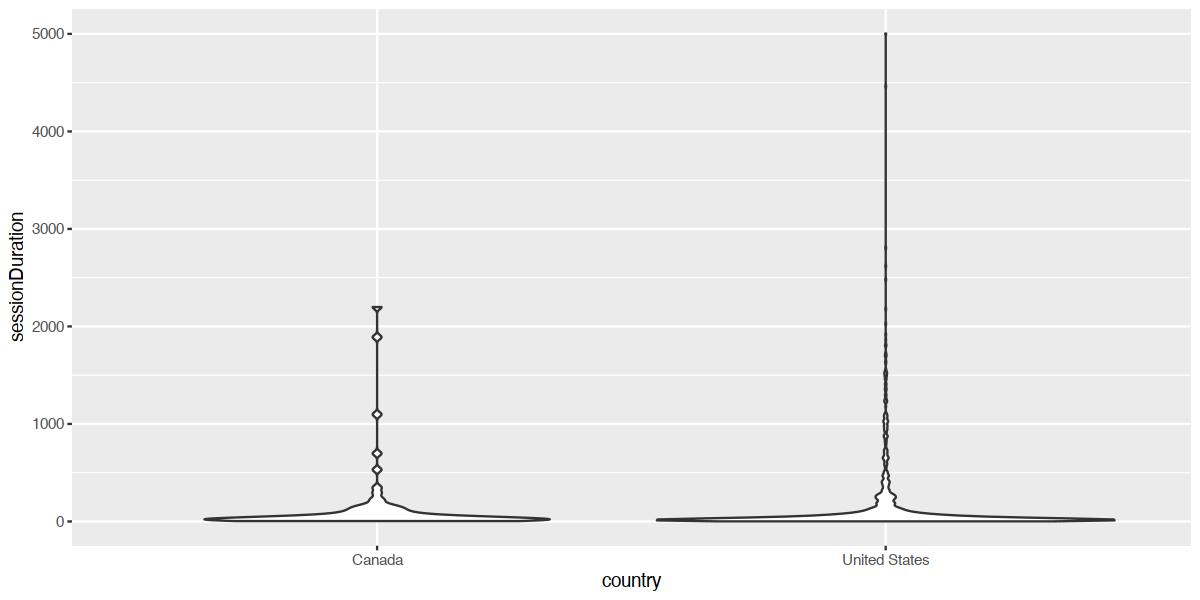

In [25]:
require(ggplot2)

options(repr.plot.width=10, repr.plot.height=5)
gg1 <- ggplot(Data_collection$Data_GeoNetwork[sessions == 1,]) 

gg1 + geom_violin(aes(country, sessionDuration))

# gg1 + facet_grid(cols = vars(country)) + 
# geom_qq(aes(sample = sessionDuration)) +
# geom_qq_line(aes(sample = sessionDuration))

The violin plots tell us that both distributions are EXTREMELY concentrated on center as well as there are huge outliers.

In [26]:
glm_gam <- glm(sessionDuration ~ country, 
               data = Data_collection$Data_GeoNetwork[sessions == 1,],
               family = 'Gamma', )
summary(glm_gam)


Call:
glm(formula = sessionDuration ~ country, family = "Gamma", data = Data_collection$Data_GeoNetwork[sessions == 
    1, ])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8333  -1.7903  -1.2293  -0.4679   7.6110  

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.0069302  0.0020141   3.441 0.000597 ***
countryUnited States -0.0002407  0.0020640  -0.117 0.907164    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Gamma family taken to be 5.997709)

    Null deviance: 3824.9  on 1388  degrees of freedom
Residual deviance: 3824.8  on 1387  degrees of freedom
AIC: 15996

Number of Fisher Scoring iterations: 8


### $Session~Duration\sim Country$ (Cox Proportional Hazard Model)
references: Miller, R., & Halpern, J. (1982). Regression with censored data. $\it Biometrika$, 69(3), 521-531.

Let $(T=t;x)\sim F,f$ where $T$ is the survival time and $x$ is some variable. The survival function $S(t;x)$ is defined as $S(t;x):=P(T>t;x)=1-F(t;x)$.

The proportional hazards model assumes that the hazard rate 
$\lambda(t; x) = \frac{f(t; x)}{1 - F(t; x)}$ is given by 

$$\lambda(t; x) = \lambda(t;0)\exp(x\beta),$$

where $\beta$ is the vector of regression coefficients. Note that $\Lambda(t;x):=\int\lambda(t;x)dx=-\log\{1-F(t;x)\}$ is a hazard function. This leads to 

$$\exp\{-\Lambda(t;x)\}=1-F(t;x)$$

which is the survival function $S(t;x)$.

In [27]:
# install.packages(c("survival", "survminer"))
library("survival")
library("survminer")

In [42]:
cox1 <- coxph(Surv(sessionDuration) ~ country,
              data =  Data_collection$Data_GeoNetwork[sessions == 1,])
cox1 %>% summary 
# %>% stargazer(type = 'text')

Call:
coxph(formula = Surv(sessionDuration) ~ country, data = Data_collection$Data_GeoNetwork[sessions == 
    1, ])

  n= 1389, number of events= 1389 

                        coef exp(coef) se(coef)     z Pr(>|z|)
countryUnited States 0.02184   1.02208  0.12199 0.179    0.858

                     exp(coef) exp(-coef) lower .95 upper .95
countryUnited States     1.022     0.9784    0.8047     1.298

Concordance= 0.501  (se = 0.003 )
Likelihood ratio test= 0.03  on 1 df,   p=0.9
Wald test            = 0.03  on 1 df,   p=0.9
Score (logrank) test = 0.03  on 1 df,   p=0.9
